Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [58]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/skin_cancer_images/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/skin_cancer_images/Test/')

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Train images: {image_count_train}, Test images: {image_count_test}')

2239
Train images: 2239, Test images: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
class_names = train_ds.class_names
print("Classes in the dataset:", class_names)

Classes in the dataset: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

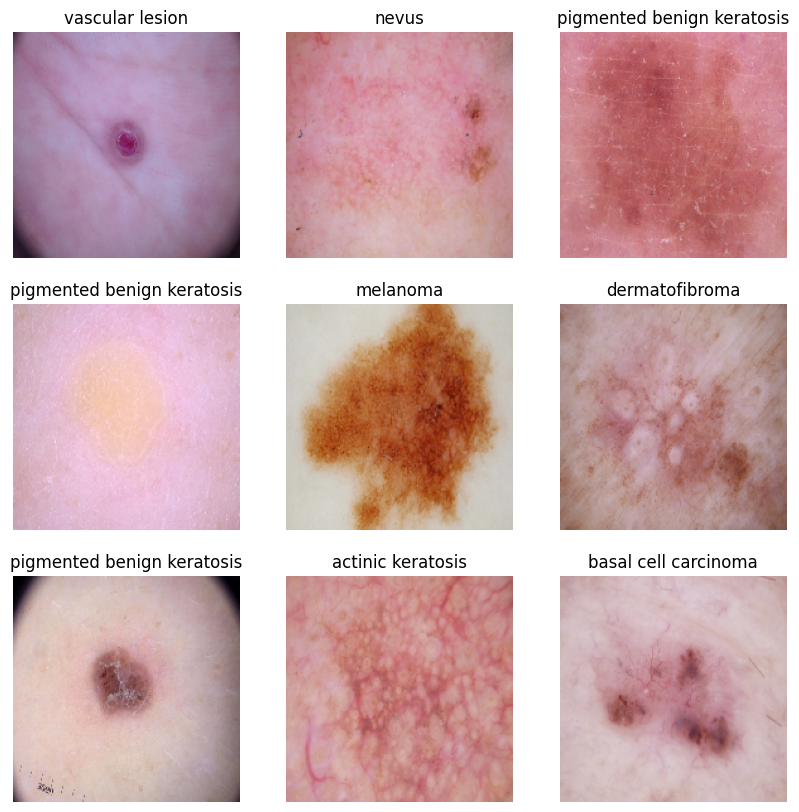

In [21]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [25]:
from tensorflow.keras import layers, models

model = models.Sequential([

    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),

    layers.Dropout(0.5),

    layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [27]:
# View the summary of all layers
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 618s 3s/step - accuracy: 0.2212 - loss: 2.0374 - val_accuracy: 0.4161 - val_loss: 1.7623
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3228 - loss: 1.8481 - val_accuracy: 0.4653 - val_loss: 1.5750
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4323 - loss: 1.6351 - val_accuracy: 0.5011 - val_loss: 1.4878
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.4450 - loss: 1.6215 - val_accuracy: 0.5257 - val_loss: 1.4760
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5245 - loss: 1.4414 - val_accuracy: 0.5257 - val_loss: 1.3801
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4958 - loss: 1.4422 - val_accuracy: 0.5257 - val_loss: 1.3757
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5026 - loss: 1.3698 - val_accuracy: 0.5302 - val_loss: 1.3484
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5378 - loss: 1.3234 - val_accuracy: 0.4855 - v

### Visualizing training results

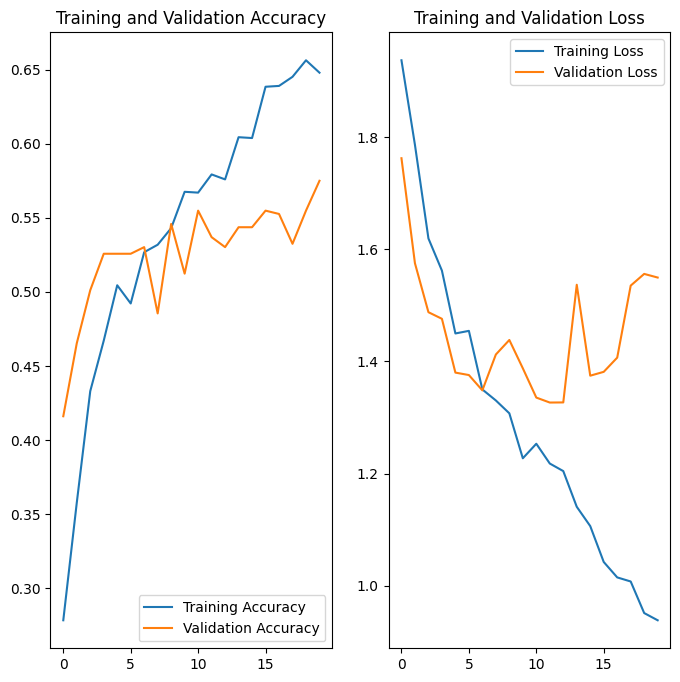

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After reviewing the model, training accuracy steadily improves to about 65% by the 20th epoch, but validation accuracy is inconsistent, hovering around 55%, which suggests the model is overfitting. The training loss decreases as expected, but the validation loss starts rising after the 10th epoch, further indicating overfitting.

### Write your findings here

In [32]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

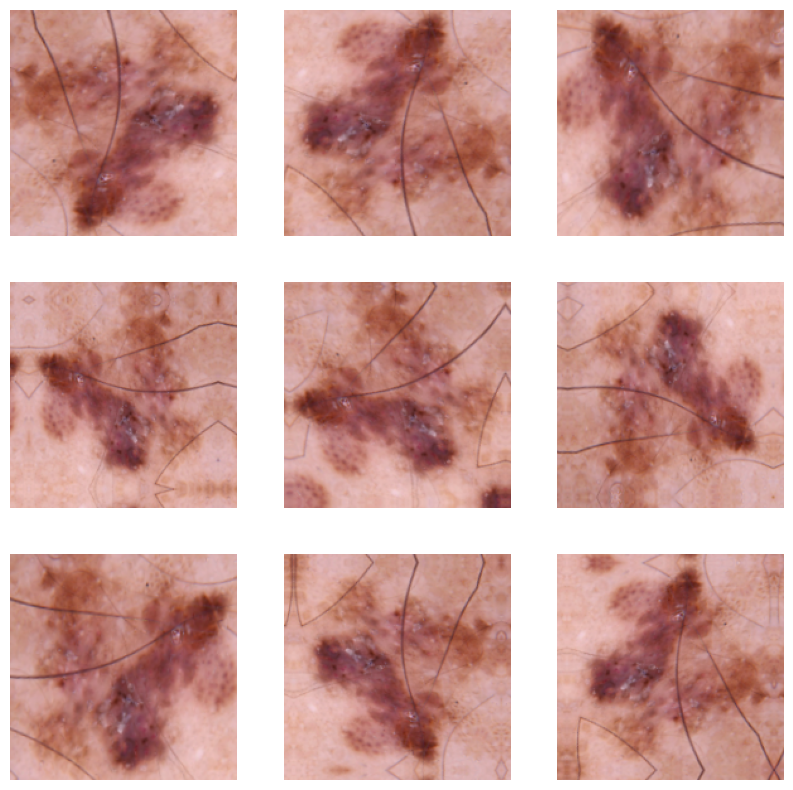

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [40]:
from tensorflow.keras import layers, models

model = models.Sequential([

    layers.InputLayer(shape=(img_height, img_width, 3)),

    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

### Compiling the model

In [41]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [42]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.1935 - loss: 2.4416 - val_accuracy: 0.3512 - val_loss: 1.9529
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.2857 - loss: 1.9225 - val_accuracy: 0.3557 - val_loss: 1.7283
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3760 - loss: 1.7772 - val_accuracy: 0.4787 - val_loss: 1.6031
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4266 - loss: 1.6244 - val_accuracy: 0.4944 - val_loss: 1.5008
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.4958 - loss: 1.5134 - val_accuracy: 0.5034 - val_loss: 1.4283
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4816 - loss: 1.5396 - val_accuracy: 0.4944 - val_loss: 1.4199
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5007 - loss: 1.4449 - val_accuracy: 0.5078 - val_loss: 1.4633
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4778 - loss: 1.4447 - val_accuracy: 0.5190 - v

### Visualizing the results

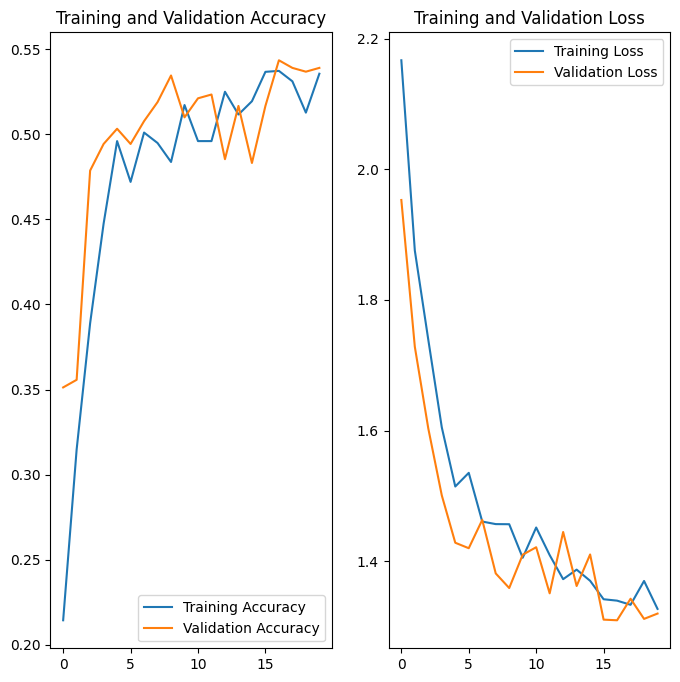

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After analyzing the model's performance, it appears that the model no longer shows clear signs of overfitting, as the training and validation accuracy curves are closely aligned. Both accuracy and loss curves indicate that the model has learned from the data, with the validation accuracy stabilizing around 55%, which is an improvement compared to the previous run. However, while the overfitting issue seems to have been addressed, the overall accuracy suggests that the model may still benefit from further tuning to better handle the complexity of the dataset.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [50]:
train_directory = "/content/gdrive/My Drive/skin_cancer_images/Train/"

class_names = os.listdir(train_directory)
class_counts = {class_name: len(os.listdir(os.path.join(train_directory, class_name))) for class_name in class_names}

print("Class Distribution in the Training Dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")

Class Distribution in the Training Dataset:
squamous cell carcinoma: 181 samples
nevus: 357 samples
pigmented benign keratosis: 462 samples
seborrheic keratosis: 77 samples
dermatofibroma: 95 samples
basal cell carcinoma: 376 samples
vascular lesion: 139 samples
melanoma: 438 samples
actinic keratosis: 114 samples


#### - Which class has the least number of samples? - seborrheic keratosis, with 77 samples
#### - Which classes dominate the data in terms proportionate number of samples?- pigmented benign keratosis with 462 samples and melanoma with 438 samples, followed by basal cell carcinoma with 376 samples and nevus with 357 samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [52]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [55]:
import Augmentor

path_to_training_dataset="/content/gdrive/My Drive/skin_cancer_images/Train/"
class_names = os.listdir(path_to_training_dataset)

for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    p = Augmentor.Pipeline(class_path)

    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)

    p.sample(500)


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A452FF92050>: 100%|██████████| 500/500 [00:22<00:00, 21.82 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7A44DB0221D0>: 100%|██████████| 500/500 [01:36<00:00,  5.19 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A44DB062AD0>: 100%|██████████| 500/500 [00:22<00:00, 22.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A452FF93640>: 100%|██████████| 500/500 [00:45<00:00, 10.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A44DB07A2F0>: 100%|██████████| 500/500 [00:22<00:00, 22.47 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A454042BF70>: 100%|██████████| 500/500 [00:20<00:00, 23.97 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A450E5A2170>: 100%|██████████| 500/500 [00:24<00:00, 20.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A44D6751CF0>: 100%|██████████| 500/500 [01:50<00:00,  4.53 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/skin_cancer_images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A450E5A2170>: 100%|██████████| 500/500 [00:23<00:00, 21.48 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [56]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [60]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

In [62]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in path_list_new]

In [63]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [66]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])

In [67]:
new_df = df2
print(new_df['Label'].value_counts())

Label
squamous cell carcinoma       500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
melanoma                      500
actinic keratosis             500
Name: count, dtype: int64


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [68]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [69]:
data_dir_train="/content/gdrive/My Drive/skin_cancer_images/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [71]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [76]:
from tensorflow.keras import layers, models

model = models.Sequential([

    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [78]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [79]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

model.save('skin_cancer_cnn_model_50_epochs.h5')

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 271ms/step - accuracy: 0.1835 - loss: 2.3004 - val_accuracy: 0.3860 - val_loss: 1.6802
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 243ms/step - accuracy: 0.3500 - loss: 1.7148 - val_accuracy: 0.4195 - val_loss: 1.5961
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 257ms/step - accuracy: 0.3886 - loss: 1.6246 - val_accuracy: 0.4180 - val_loss: 1.5371
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 253ms/step - accuracy: 0.4004 - loss: 1.5635 - val_accuracy: 0.4781 - val_loss: 1.4052
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - accuracy: 0.4331 - loss: 1.4813 - val_accuracy: 0.4878 - val_loss: 1.3813
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.4536 - loss: 1.4249 - val_accuracy: 0.4514 - val_loss: 1.3601
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 241ms/step - accuracy: 0.4629 - loss: 1.4011 - val_accuracy: 0.4848 - val_loss: 1.3498
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.4645 - loss: 1

#### **Todo:**  Visualize the model results

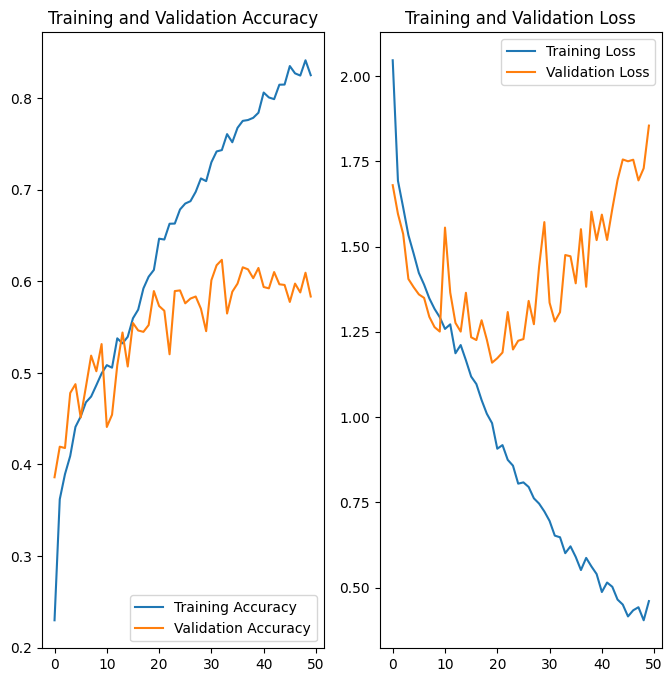

In [80]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The model shows strong performance on the training data, with accuracy climbing above 80%, but it's clear there's still a problem with overfitting since the validation accuracy stays around 55-60% and the validation loss keeps rising. This tells us that while balancing the classes helped stabilize the training, it wasn't enough to completely fix the overfitting issue. The model is getting too focused on the training data and struggling when faced with new data.